<a href="https://colab.research.google.com/github/tomonari-masada/course-nlp2020/blob/master/11_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 標準使用ライブラリー
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc
import os
import shutil
from icecream import ic
from tqdm import tqdm_notebook as tqdm 

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 追記
import json
import datetime
import math
plt.style.use('dark_background')

# debug
#%pdb on

import pixiedust #%pixie_debugger

# tfがエラーはかないため
# tfがエラーはかないため
#import tensorflow as tf
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="5"
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)


Pixiedust database opened successfully


In [9]:
import pandas as pd
import re

df = pd.read_csv("./result0605.csv", engine='python')

type(df["description"])
docs = df["description"].to_list()

In [10]:
print(len(docs))

93794


In [11]:
print(docs[0][:1000])

漫画、アニメ、声優垢。 RT多め気ままに呟きます。伏線系の漫画好き。古川慎さん・小林裕介さん・河西健吾さん ・田丸篤志さん推し


### Neologdを使ってtokenizeする

In [19]:
# docs

In [126]:
import subprocess
cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path_neologd = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
import MeCab
m=MeCab.Tagger("-Ochasen -d "+str(path_neologd))

# def remove_emoji(string):
#     emoji_pattern = re.compile("["
#                            u"\U0001F600-\U0001F64F"  # emoticons
#                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            u"\U00002702-\U000027B0"
#                            u"\U000024C2-\U0001F251"
#                            "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r'', string)

def neolog_prep_text( text):
  items = (re.split('[\t,]', line) for line in m.parse(text).split('\n'))
#   for tmp_word in words :
#     if (tmp_word[0] in ('EOS', '', 't', 'ー') and not re.match( '名詞' ,tmp_word[3]  )):
#       continue
#     else:
#       remove_emoji(tmp_word[0])
      
  words = [item[0]
         for item in items
         if (item[0] not in ('EOS', '', 't', 'ー') and re.match( '名詞' ,item[3]  ) and item[0] not in emoji.UNICODE_EMOJI["en"]
              )]
  return words

* tokenizationの実行

In [ ]:
from tqdm import tqdm

new_docs = list()
for doc in tqdm(docs):
  new_docs.append( neolog_prep_text(str(doc)) )

 48%|████▊     | 45484/93794 [00:11<00:11, 4315.03it/s]

* tokenizationの結果を確認

In [78]:
print(new_docs[5])

['過去', 'ジャパリカート', '動画', 'TSUMURI', 'KART', 'VRChat', 'ワリスノ', 'MK', '8', 'DX', '一位', 'りし', 'た人', '社会', '出て', '配信', 'https', 'co', 'FJoitl', '8', 'JHE', 'ヘッダ', '猫', '飼い主', 'smmmmm']


* 各文書を長い文字列で表しなおす（CountVectorizerを後で使うため）

In [32]:
corpus = [' '.join(doc) for doc in new_docs]

In [112]:
import emoji

new_docs[1][8] in emoji.UNICODE_EMOJI


False

In [119]:
new_docs[1][8] 

True

In [122]:
emoji.UNICODE_EMOJI.keys()

dict_keys(['en', 'es', 'pt', 'it'])

In [111]:
remove_emoji(new_docs[1][8] )

''

## 11-02 データ行列の作成
* NMFの場合、TF-IDFで単語の重みを求めて各文書をベクトル化する。
* LDAの場合、単に単語の出現頻度を重みとして各文書をベクトル化する。

### sklearnのCountVectorizerで疎行列化する

* 全文書の半分より多い文書に現れる単語は、高頻度語とみなして削除する。
* 10件未満の文書にしか現れない単語は、低頻度語とみなして削除する。

In [89]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.5, min_df=10, stop_words='english')
X = vectorizer.fit_transform(corpus[0:100])

In [35]:
print(X[0])

  (0, 11012)	2
  (0, 4597)	1
  (0, 8933)	1
  (0, 2602)	1
  (0, 8968)	1
  (0, 10802)	1
  (0, 9174)	1
  (0, 8629)	1
  (0, 3801)	4
  (0, 9435)	1


In [90]:
print(vectorizer.get_feature_names())

['https', 'さん', 'アニメ', 'フォロー', '好き']


In [37]:
print(len(vectorizer.get_feature_names()))

13334


* 文書数と語彙サイズを変数にセット

In [38]:
X.shape

(93794, 13334)

In [39]:
n_samples, n_features = X.shape

### TF-IDFで各文書における単語の重みを計算する

In [40]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
Xtfidf = tfidf.fit_transform(X)

In [41]:
print(Xtfidf[0])

  (0, 11012)	0.3619814029513076
  (0, 10802)	0.28072872053691006
  (0, 9435)	0.4266360385078374
  (0, 9174)	0.1117347040754048
  (0, 8968)	0.2000545715345298
  (0, 8933)	0.2142557603293289
  (0, 8629)	0.3949643950455237
  (0, 4597)	0.14466654623373754
  (0, 3801)	0.5507703817873795
  (0, 2602)	0.1716311076156643


In [42]:
Xtfidf.shape

(93794, 13334)

* 抽出するトピックの個数は、今回は20個とする。

In [43]:
n_components = 20

## 11-03 NMFでトピック抽出
* まず、TF-IDFのデータ行列を使って　NMFによってトピック抽出を試みる。
 * NMFのパラメータ群は下記サンプルコードのまま。
 * https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

### NMFとLDAのインポート

In [44]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

### NMFによるトピック抽出の実行

In [45]:
from time import time

print((f"Fitting the NMF model (generalized Kullback-Leibler "
  f"divergence) with tf-idf features, n_samples={n_samples} "
  f"and n_features={n_features}"))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5,
          verbose=1)
nmf.fit(Xtfidf)
print(f"done in {time() - t0:0.3f}s.")

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=93794 and n_features=13334
Epoch 10 reached after 4.601 seconds, error: 1602.527327
Epoch 20 reached after 9.005 seconds, error: 1599.430766
Epoch 30 reached after 13.378 seconds, error: 1598.613413
Epoch 40 reached after 17.778 seconds, error: 1598.221763
Epoch 50 reached after 22.173 seconds, error: 1597.975820
Epoch 60 reached after 26.580 seconds, error: 1597.816817
done in 28.479s.


* NMFにおける各コンポーネントは、それぞれのトピックにおける単語の重要度を表すベクトルとして表現されている。

In [46]:
nmf.components_

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.55476776e-07, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.49305624e-03, 8.76861678e-03, 5.55201985e-03, ...,
        1.53789487e-02, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 4.49836367e-09, ...,
        2.74432478e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.30288707e-03, 2.80616059e-14],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### トピックの重要語を取り出す関数の定義

In [47]:
def get_top_words(model, feature_names, n_top_words=30):
  top_features = list()
  weights = list()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features.append([feature_names[i] for i in top_features_ind])
    weights.append(topic[top_features_ind])
  return top_features, weights

### NMFの各コンポーネントから重要語を取り出す

In [48]:
top_words, weights = get_top_words(nmf, vectorizer.get_feature_names())

In [49]:
print(top_words[0])

['nan', 'るん', 'りさん', 'りさ', 'りこ', 'りく', 'りきゃこ', 'りか', 'りお', 'りえ', 'りぃ', 'らーめん', 'らんま', 'らん', 'らら', 'らむ', 'らぶりつ', 'らぶ', 'らふ', 'らじ', 'らしんばん', 'らく', 'らいむ', 'らいぶ', 'らい', 'りし', 'りす', 'りすなー', 'りんりん', 'るろ剣']


In [50]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

In [51]:
topic_words[0]

{'nan': 11.224384196625653,
 'るん': 0.0,
 'りさん': 0.0,
 'りさ': 0.0,
 'りこ': 0.0,
 'りく': 0.0,
 'りきゃこ': 0.0,
 'りか': 0.0,
 'りお': 0.0,
 'りえ': 0.0,
 'りぃ': 0.0,
 'らーめん': 0.0,
 'らんま': 0.0,
 'らん': 0.0,
 'らら': 0.0,
 'らむ': 0.0,
 'らぶりつ': 0.0,
 'らぶ': 0.0,
 'らふ': 0.0,
 'らじ': 0.0,
 'らしんばん': 0.0,
 'らく': 0.0,
 'らいむ': 0.0,
 'らいぶ': 0.0,
 'らい': 0.0,
 'りし': 0.0,
 'りす': 0.0,
 'りすなー': 0.0,
 'りんりん': 0.0,
 'るろ剣': 0.0}

### 重要語をワードクラウドで可視化

In [52]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

* ワードクラウドから除去するストップワードを確認する。

In [53]:
print(STOPWORDS)

{'ever', "hadn't", 'is', 'with', 'whom', "you've", "here's", 'we', 'from', 'have', 'your', 'during', "how's", 'very', "hasn't", 'yourselves', 'into', 'most', "let's", 'under', "i've", 'than', 'me', 'our', 'once', "you'd", 'ought', "she'll", "we'd", 'theirs', 'an', 'if', 'for', 'am', 'not', "i'm", "she's", 'until', 'also', 'herself', 'few', 'however', "we'll", 'his', "you'll", 'each', 'against', 'because', 'then', "wouldn't", 'which', 'who', 'like', 'that', 'how', "you're", 'hence', "there's", 'www', 'their', 'yourself', "he'd", 'having', "when's", 'again', "couldn't", "i'd", 'been', 'get', 'ourselves', "shan't", "haven't", "don't", "he's", 'more', "can't", 'over', 'to', 'other', 'here', 'i', 'as', 'but', "i'll", "mustn't", "he'll", "where's", 'no', 'what', 'http', 'out', "didn't", 'her', 'about', "weren't", 'has', 'r', 'just', 'since', 'and', "they'd", 'there', 'did', 'why', "won't", "what's", 'such', 'were', 'of', 'ours', 'through', 'com', 'otherwise', 'any', 'being', 'below', 'are', 

* ワードクラウドを描画

In [54]:
FONT_PATH = "/usr/share/fonts/opentype/ipaexfont-mincho/ipaexm.ttf"
cloud = WordCloud(stopwords=STOPWORDS,
                  font_path=FONT_PATH,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

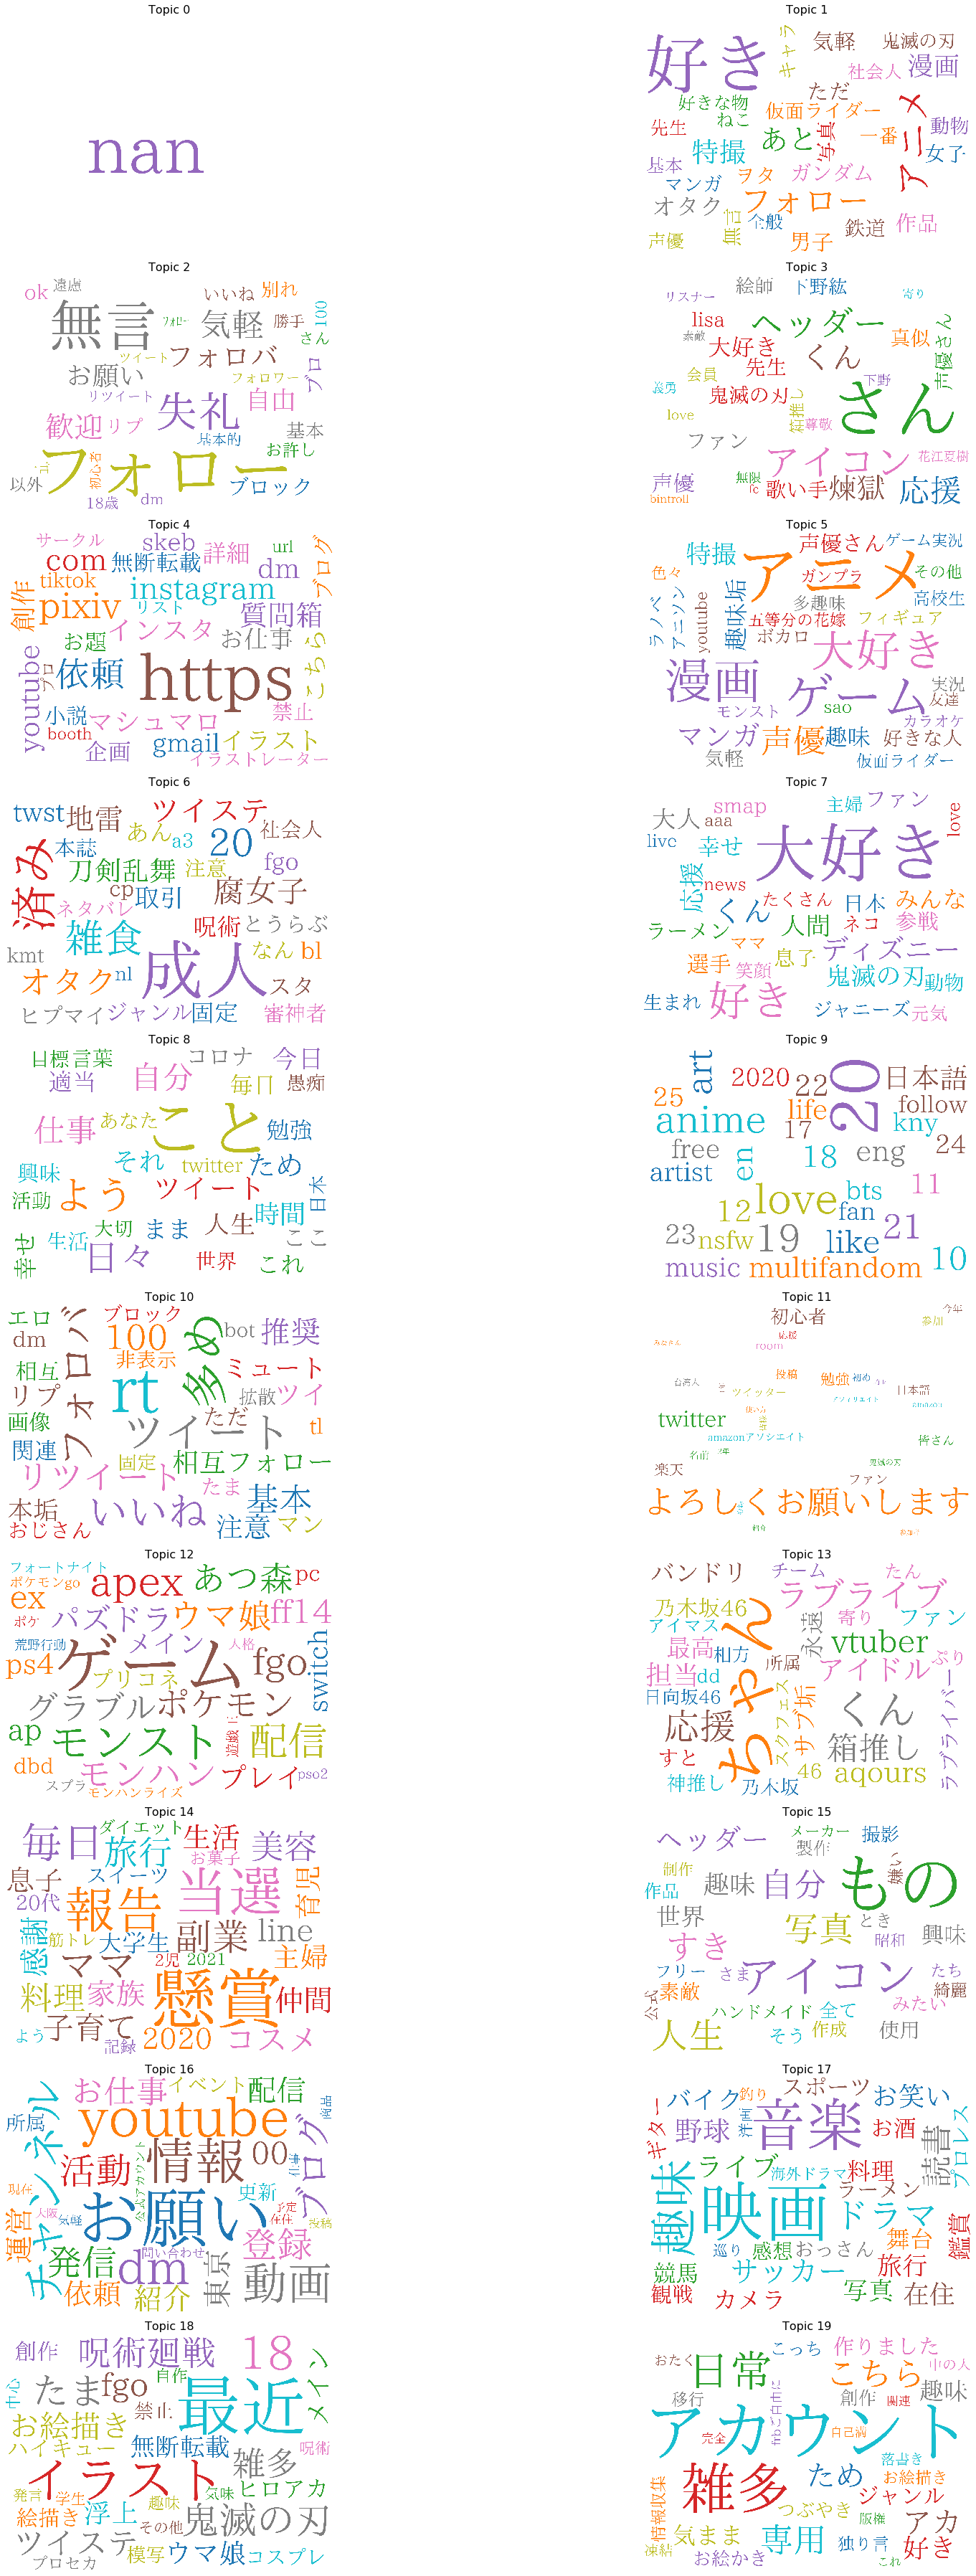

In [55]:
fig, axes = plt.subplots(10, 2, figsize=(32, 50), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=500)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

## 11-04 LDAでトピック抽出

### LDAによるトピック抽出の実行

In [56]:
lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=20,
                                topic_word_prior=0.01,
                                learning_method='online',
                                learning_offset=50,
                                batch_size=200,
                                mean_change_tol=1e-4,
                                random_state=1,
                                evaluate_every=1,
                                verbose=1)

In [57]:
print((f"Fitting LDA models with tf features, "
  f"n_samples={n_samples} and n_features={n_features}"))
t0 = time()
lda.fit(X)
print(f"done in {time() - t0:0.3f}s.")

Fitting LDA models with tf features, n_samples=93794 and n_features=13334
iteration: 1 of max_iter: 20, perplexity: 9040.3756
iteration: 2 of max_iter: 20, perplexity: 8859.8218
iteration: 3 of max_iter: 20, perplexity: 8819.3578
iteration: 4 of max_iter: 20, perplexity: 8806.0251
iteration: 5 of max_iter: 20, perplexity: 8798.3521
iteration: 6 of max_iter: 20, perplexity: 8795.7893
iteration: 7 of max_iter: 20, perplexity: 8795.7083
done in 295.643s.


### LDAの各トピックから高確率語を取り出す

In [58]:
top_words, weights = get_top_words(lda, vectorizer.get_feature_names())

In [59]:
print(top_words[0])

['nan', 'すき', 'ただ', 'シリーズ', '制作', 'たくさん', 'ジョジョ', '2021年', '開始', '24', 'ソシャゲ', '尊敬', '麻雀', '洋楽', '卒業', '引退', 'うさぎ', 'ポケカ', '映画館', '公認', 'sixtones', 'メンバー', 'サロン', 'snowman', 'bish', 'テニス', '仲良し', '少女', '飛行機', 'おすすめ']


In [60]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

### 高確率語をワードクラウドで可視化

In [61]:
cloud = WordCloud(stopwords=STOPWORDS,
                                font_path=FONT_PATH,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

In [62]:
import datetime
(datetime.datetime.now() + datetime.timedelta(hours=9) ) .strftime('%m%d_%H%M')

'0606_1653'

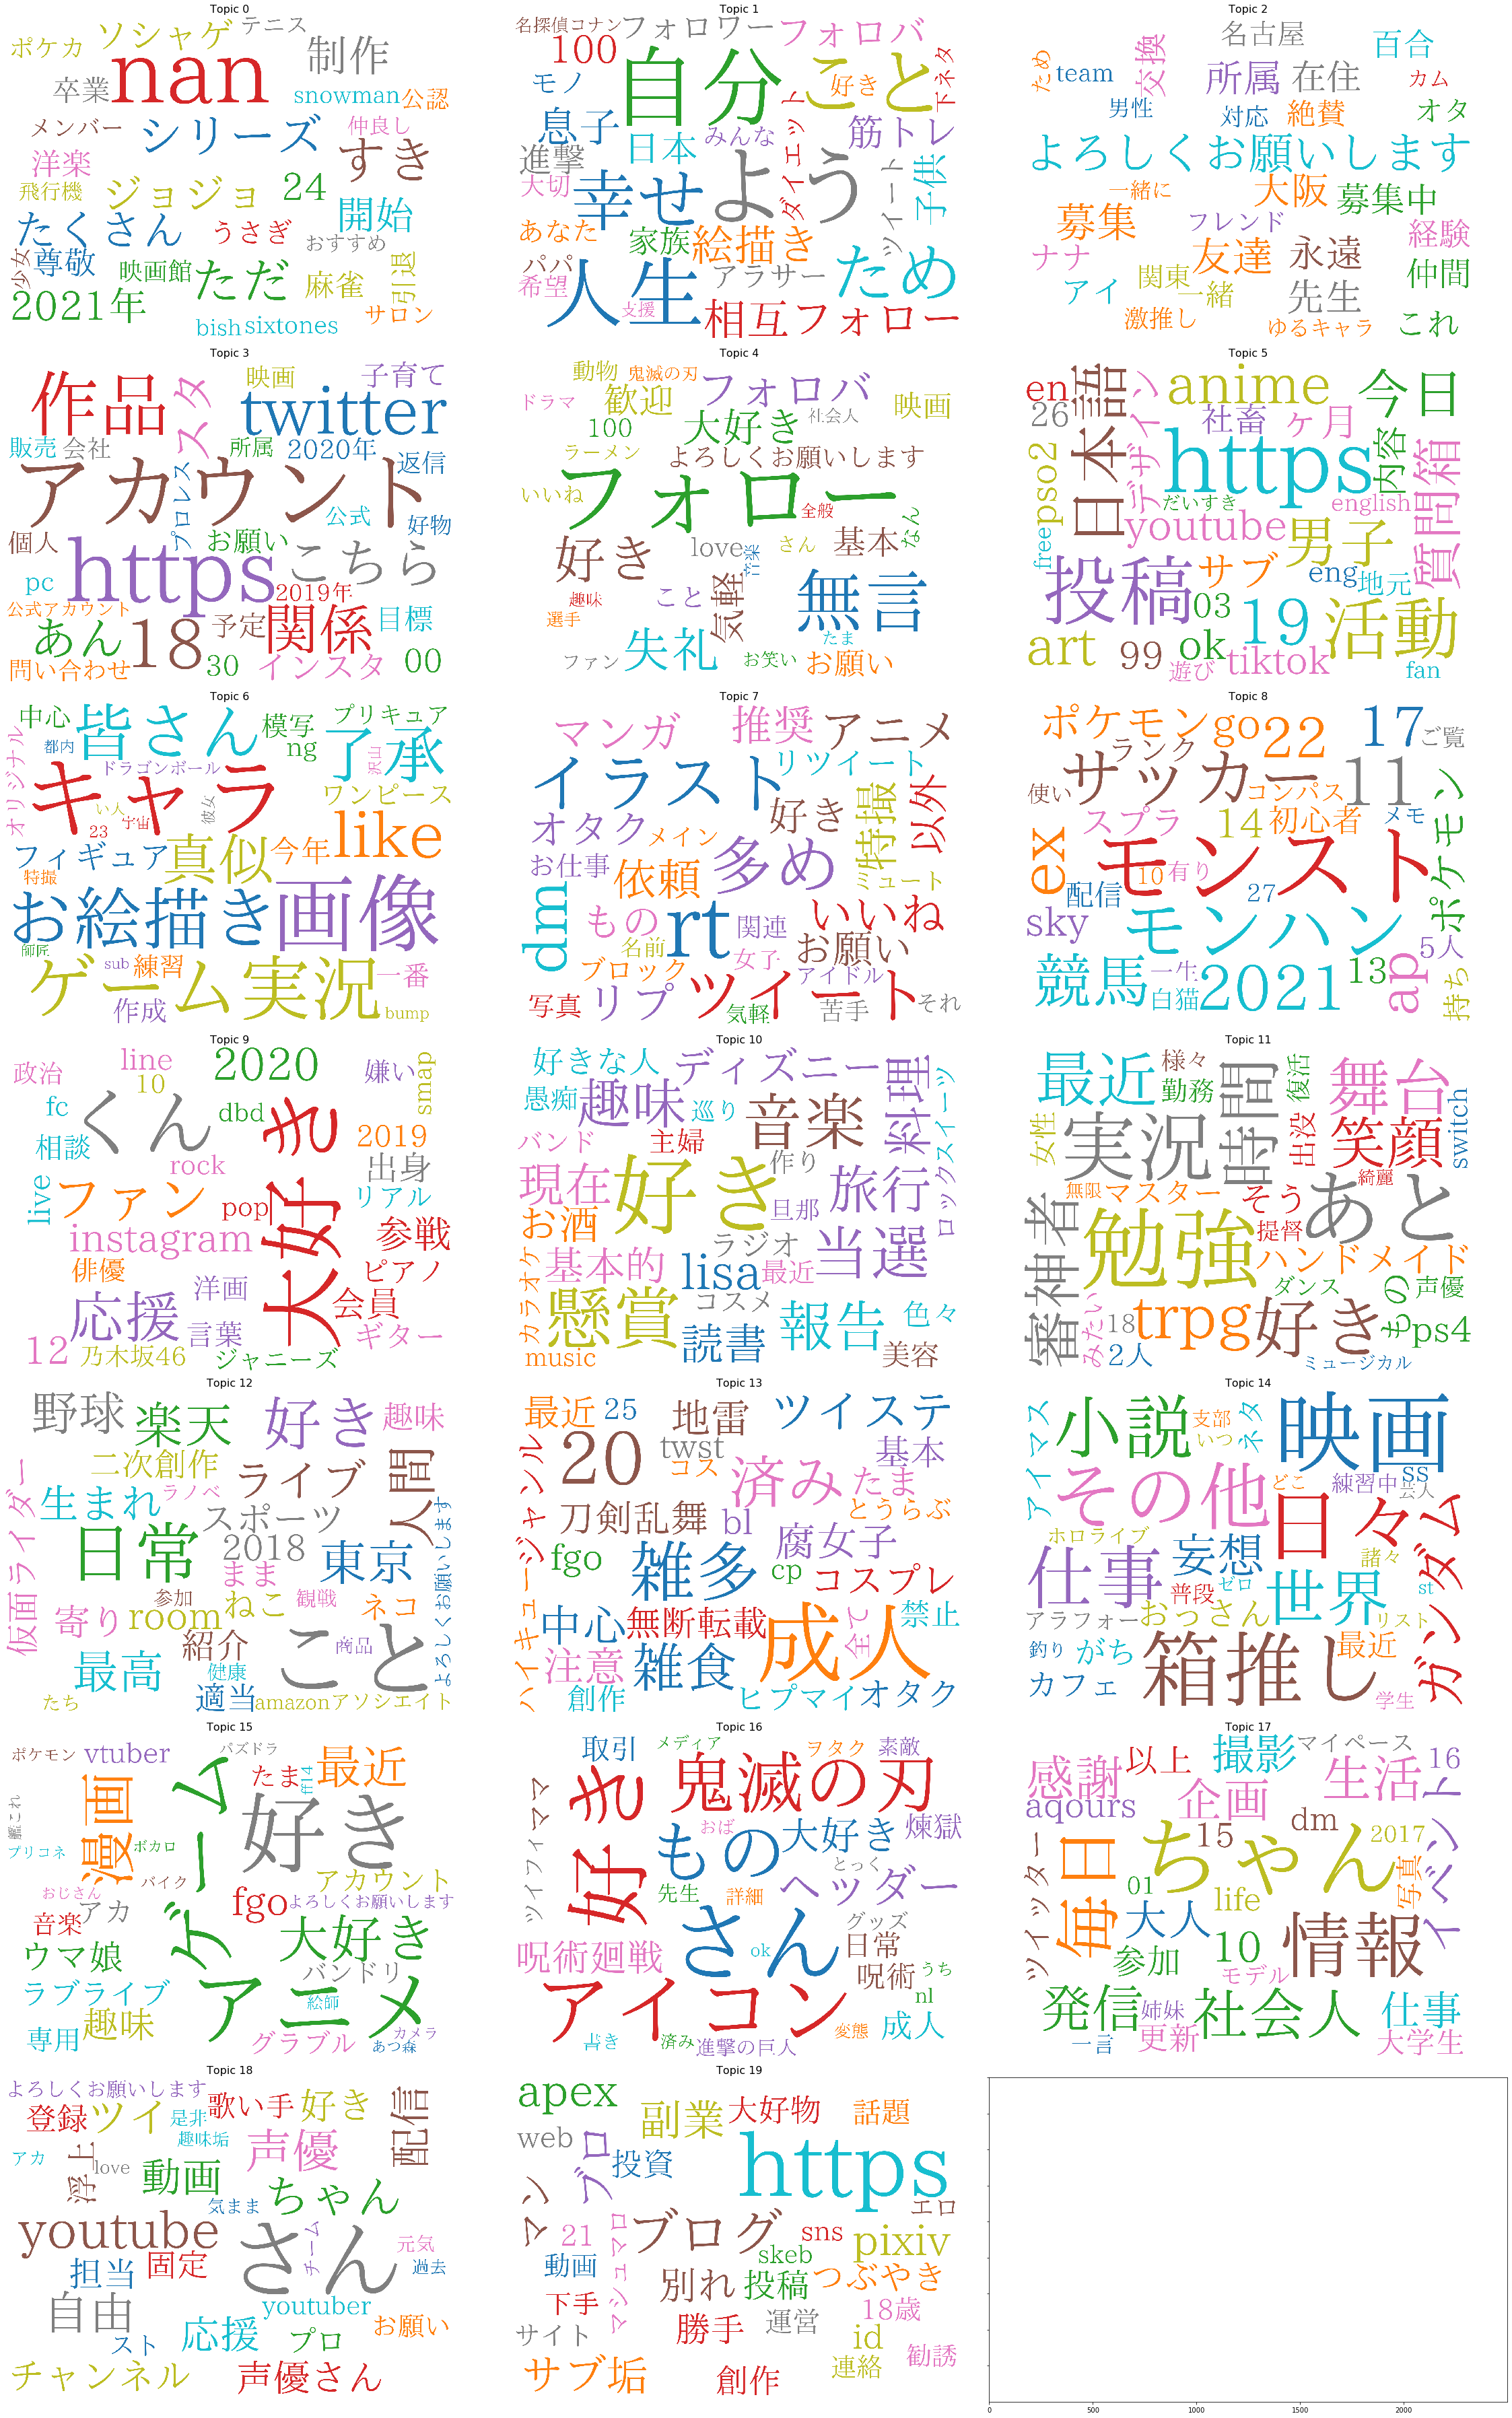

In [63]:
# fig, axes = plt.subplots(5, 4, figsize=(16, 25), sharex=True, sharey=True)
fig, axes = plt.subplots(7, 3, figsize=(32, 50), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    
  if i > len(topic_words)-1:
    break

  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=500)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()


from matplotlib.backends.backend_pdf import PdfPages

import datetime
pdf = PdfPages( 
(datetime.datetime.now() + datetime.timedelta(hours=9) ) .strftime('%m%d_%H%M') + 'topic.pdf')


fignums = plt.get_fignums()
for fignum in fignums:
    plt.figure(fignum)
    pdf.savefig()

pdf.close()

In [64]:
# !pip install pyLDAvis

In [65]:
import pyLDAvis
import pyLDAvis.sklearn

In [66]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, X, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
15     -10.878068   10.538728       1        1  9.111957
4      -60.884026  -75.591820       2        1  8.511637
13      -2.336119  -53.289074       3        1  7.721169
7      -61.385319  -12.914634       4        1  6.839423
16     -28.737743  126.296997       5        1  6.182752
18       1.066606 -123.552811       6        1  5.905473
3       45.140720   -7.947869       7        1  5.483291
10    -140.795975  -98.530548       8        1  5.466046
17      61.531681  -83.240562       9        1  4.828361
9      -72.563057 -140.396881      10        1  4.656399
19      15.984491   63.578186      11        1  4.554150
1     -160.851624   68.945145      12        1  4.293134
12      85.961830   51.922935      13        1  4.250949
11     -99.020836  109.936348      14        1  3.569866
5     -176.764130   -8.681684      15        1  3.446452
14    -117.189880  -37.420200      16        1  3.347453
8      108.829918  -22.946203      17        1  3.256795
2       47.588097  121.934814      18        1  3.113000
6     -106.467834   30.176889      19        1  3.047476
0      -50.613804   59.328842      20        1  2.414216, topic_info=        Term          Freq         Total Category  logprob  loglift
6521    フォロー  14274.000000  14274.000000  Default  30.0000  30.0000
3801      さん  16398.000000  16398.000000  Default  29.0000  29.0000
1662   https  10620.000000  10620.000000  Default  28.0000  28.0000
9174      好き  25649.000000  25649.000000  Default  27.0000  27.0000
2186     nan   5244.000000   5244.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
12788     開催    102.303115    102.496095  Topic20  -5.4579   3.7219
6403     パンダ    100.764920    100.957900  Topic20  -5.4730   3.7219
8518      卒業    211.205659    281.311709  Topic20  -4.7330   3.4372
7040    メンバー    139.235284    309.154878  Topic20  -5.1496   2.9261
3480    おすすめ    103.259081    178.291399  Topic20  -5.4486   3.1776

[870 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
0          7  0.998949    00
5          9  0.999319    01
11         9  0.996929    02
15        15  1.000457    03
17         9  0.997577    05
...      ...       ...   ...
13099     10  0.011293  鬼滅の刃
13099     12  0.010038  鬼滅の刃
13099     19  0.008156  鬼滅の刃
13144     20  0.998660    麻雀
13222      2  1.000139   ｱﾆﾒ

[1053 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 5, 14, 8, 17, 19, 4, 11, 18, 10, 20, 2, 13, 12, 6, 15, 9, 3, 7, 1])

In [73]:
import numpy as np
sum(df["description"] == "nan")


0